In [2]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.19.1


In [3]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arar, Ets, Arima
from skforecast.recursive import ForecasterStats, ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
import aeon
from aeon.forecasting.stats import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as statsmodels_Arima
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")
print(f"aeon version      : {aeon.__version__}")

skforecast version: 0.19.1
aeon version      : 1.3.0


# Fuel consumption dataset

In [4]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 6 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-04-01,202319.8164,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-05-01,206259.1523,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-09-01,687649.2852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1989-10-01,669889.1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1989-11-01,601413.8867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


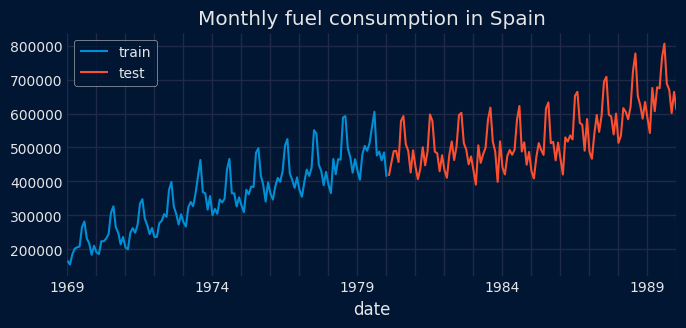

In [5]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Compare ets from skforecast, aeon and statsmodels

## Performance Note

⚠️ **Important**: The first call to ETS includes JIT compilation (~0.4s overhead). Subsequent calls are much faster (~0.005s). This is a one-time cost per Python session.

To get accurate performance measurements, run each cell **twice** and use the second timing.

In [6]:
# Warmup: Pre-compile JIT functions (run this once after importing)
# ==============================================================================
# print("Warming up JIT cache...")
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     dummy_forecaster = ForecasterStats(estimator=Ets(model="ANN"))
#     dummy_forecaster.fit(y=data_train['y'].iloc[:20])
#     _ = dummy_forecaster.predict(steps=1)
# print("✅ JIT cache ready. Subsequent ETS calls will be fast (~0.005s per fit)")

In [7]:
# ARIMA skforecast
# ==============================================================================
forecaster = ForecasterStats(
                estimator = Arima(
                    order=(0, 1, 1),
                    seasonal_order=(1, 1, 1),
                    m =12
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_skforecast = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_skforecast = end - start
prediction_intervals_skforecast = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_skforecast} seconds")

Training time ARIMA skforecast  : 0.39710199700130033 seconds
Prediction time ARIMA skforecast: 0.008994127998448675 seconds


/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")


In [8]:
# ARIMA statsmodels
# ==============================================================================
forecaster = ForecasterStats(
                estimator = Sarimax(
                    order=(0, 1, 1),
                    seasonal_order=(1, 1, 1, 12)
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_statsmodels = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_statsmodels = end - start
prediction_intervals_statsmodels = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_statsmodels} seconds")

Training time ARIMA skforecast  : 0.26925573800326674 seconds
Prediction time ARIMA skforecast: 0.010955522997392109 seconds


In [9]:
# ARIMA aeon
# ==============================================================================
# Instantiate AEON ARIMA with seasonal parameters if supported, fallback otherwise.
try:
    estimator_aeon = ARIMA(p=0, d=1, q=1, seasonal_order=(1, 1, 1, 12))
except TypeError:
    try:
        estimator_aeon = ARIMA(p=0, d=1, q=1, sp=12)
    except TypeError:
        estimator_aeon = ARIMA(p=0, d=1, q=1)

forecaster = ForecasterStats(
                 estimator=estimator_aeon
             )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_aeon = end - start
print(f"Training time ARIMA aeon  : {time_fit_arima_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_aeon = end - start
print(f"Prediction time ARIMA aeon: {time_pred_arima_aeon} seconds")

Training time ARIMA aeon  : 0.06443950199900428 seconds
Prediction time ARIMA aeon: 0.002034951001405716 seconds


In [10]:
# Nixtla StatsForecast Arima
# ==============================================================================
df_nixtla = data_train['y'].reset_index()
df_nixtla.columns = ['ds', 'y']
df_nixtla['unique_id'] = 'fuel'

start = timeit.default_timer()
sf = StatsForecast(
    models=[statsmodels_Arima(order=(0, 1, 1), seasonal_order=(1, 1, 1), season_length=12)],
    freq='MS'
)
sf.fit(df=df_nixtla)
end = timeit.default_timer()
time_fit_arima_nixtla = end - start
print(f"Training time ARIMA nixtla  : {time_fit_arima_nixtla} seconds")

start = timeit.default_timer()
predictions_nixtla_df = sf.predict(h=24, level=[95])
end = timeit.default_timer()
time_pred_arima_nixtla = end - start

# Extract predictions and prediction intervals
predictions_nixtla = predictions_nixtla_df['ARIMA'].values
predictions_nixtla = pd.Series(predictions_nixtla, index=pd.date_range(start=data_test.index[0], periods=24, freq='MS'))

prediction_intervals_nixtla = pd.DataFrame({
    'lower_bound': predictions_nixtla_df['ARIMA-lo-95'].values,
    'upper_bound': predictions_nixtla_df['ARIMA-hi-95'].values
}, index=predictions_nixtla.index)

print(f"Prediction time ARIMA nixtla: {time_pred_arima_nixtla} seconds")

Training time ARIMA nixtla  : 0.05309266899712384 seconds
Prediction time ARIMA nixtla: 0.0041952920000767335 seconds


In [11]:
# Table of times
# ==============================================================================
times_arima = pd.DataFrame({
    'fit_time_seconds': [time_fit_arima_skforecast, time_fit_arima_aeon, time_fit_arima_nixtla, time_fit_arima_statsmodels],
    'predict_time_seconds': [time_pred_arima_skforecast, time_pred_arima_aeon, time_pred_arima_nixtla, time_pred_arima_statsmodels]
}, index=['ARIMA skforecast', 'ARIMA aeon', 'ARIMA nixtla', 'ARIMA statsmodels'])
times_arima.sort_values(by='fit_time_seconds')

,fit_time_seconds,predict_time_seconds
ARIMA nixtla,0.053093,0.004195
ARIMA aeon,0.064440,0.002035
ARIMA statsmodels,0.269256,0.010956
ARIMA skforecast,0.397102,0.008994


,skforecast,aeon,nixtla,statsmodels
1980-02-01,0.0,420023.437419,419482.712173,405808.138205
1980-03-01,0.0,420023.437419,490917.596449,480986.215106
1980-04-01,0.0,420023.437419,487253.024913,490994.139657
1980-05-01,0.0,420023.437419,499252.980036,490137.797998
1980-06-01,0.0,420023.437419,511334.335467,507401.818212
1980-07-01,0.0,420023.437419,611222.083529,579974.035734
1980-08-01,0.0,420023.437419,622504.821197,608998.418148
1980-09-01,0.0,420023.437419,523394.526344,493716.914728
1980-10-01,0.0,420023.437419,506820.101476,492013.366250
1980-11-01,0.0,420023.437419,467549.832349,459820.621056


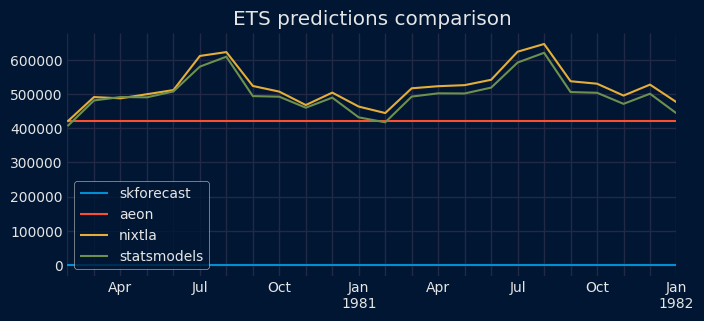

In [12]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'nixtla'    : predictions_nixtla,
    'statsmodels': predictions_statsmodels
})
display( predictions )
predictions.plot(figsize=(7, 3), title='ETS predictions comparison');

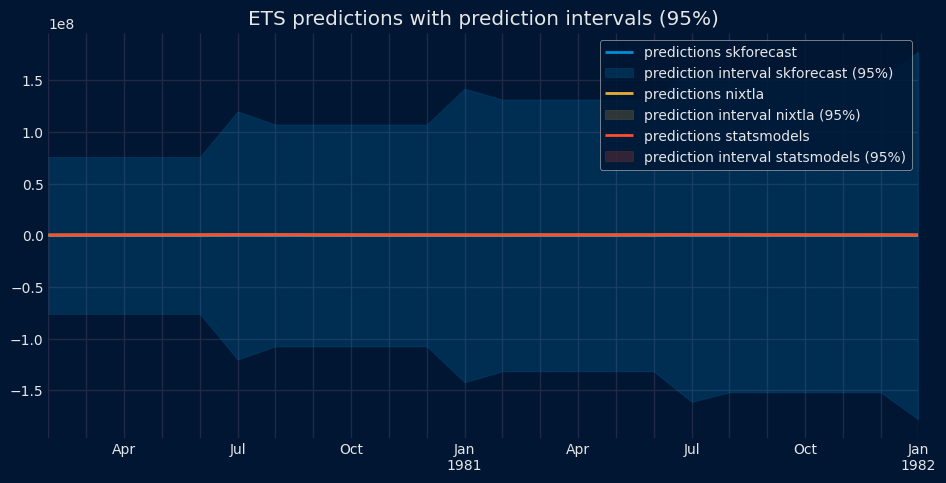

In [13]:
# Plot predictions with prediction intervals
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 5))

# Skforecast
predictions_skforecast.plot(ax=ax, label='predictions skforecast', color='C0', linewidth=2)
ax.fill_between(
    prediction_intervals_skforecast.index,
    prediction_intervals_skforecast['lower_bound'],
    prediction_intervals_skforecast['upper_bound'],
    color='C0',
    alpha=0.2,
    label='prediction interval skforecast (95%)'
)

# Nixtla
predictions_nixtla.plot(ax=ax, label='predictions nixtla', color='C2', linewidth=2)
ax.fill_between(
    prediction_intervals_nixtla.index,
    prediction_intervals_nixtla['lower_bound'],
    prediction_intervals_nixtla['upper_bound'],
    color='C2',
    alpha=0.2,
    label='prediction interval nixtla (95%)'
)

# Statsmodels
predictions_statsmodels.plot(ax=ax, label='predictions statsmodels', color='C1', linewidth=2)
ax.fill_between(
    prediction_intervals_statsmodels.index,
    prediction_intervals_statsmodels['lower_bound'],
    prediction_intervals_statsmodels['upper_bound'],
    color='C1',
    alpha=0.2,
    label='prediction interval statsmodels (95%)'
)

ax.set_title('ETS predictions with prediction intervals (95%)')
ax.legend();

In [14]:
# Compare prediction interval widths
# ======================================================================================
interval_widths = pd.DataFrame({
    'skforecast': prediction_intervals_skforecast['upper_bound'] - prediction_intervals_skforecast['lower_bound'],
    'nixtla': prediction_intervals_nixtla['upper_bound'] - prediction_intervals_nixtla['lower_bound'],
    'statsmodels': prediction_intervals_statsmodels['upper_bound'] - prediction_intervals_statsmodels['lower_bound']
})

print("\nPrediction Interval Widths Summary (95% confidence):")
print("=" * 60)
print(interval_widths.describe().T[['mean', 'std', 'min', 'max']])
print("\nAverage interval width:")
print(interval_widths.mean().sort_values())


Prediction Interval Widths Summary (95% confidence):
                     mean           std           min           max
skforecast   2.446006e+08  6.139532e+07  1.518871e+08  3.562072e+08
nixtla       8.367724e+04  1.418883e+04  6.057850e+04  1.059388e+05
statsmodels  2.035199e+05  7.676289e+04  8.387552e+04  3.275994e+05

Average interval width:
nixtla         8.367724e+04
statsmodels    2.035199e+05
skforecast     2.446006e+08
dtype: float64


In [15]:
# Backtesting ForecasterStats with ETS skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Arima(
                     order=(1, 1, 1),
                     seasonal_order=(1, 1, 1),
                     m=12
                 )
             )

start = timeit.default_timer()
metric_ets_skforecast, pred_ets_skforecast = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_skforecast = stop - start

/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")


  0%|          | 0/10 [00:00<?, ?it/s]

/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence problem
  warnings.warn("Possible convergence problem")
/home/joaquin/Documents/GitHub/skforecast/skforecast/stats/arima/_arima_base.py:2469: UserWarning: Possible convergence 

In [16]:
# Backtesting ForecasterStats aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=ARIMA(p=0, d=1, q=12)
             )

start = timeit.default_timer()
metric_ets_aeon, pred_ets_aeon = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_ets_aeon = stop - start

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# Backtesting ForecasterStats with ETS nixtla
# ==============================================================================
# Note: Nixtla's StatsForecast doesn't integrate directly with skforecast's backtesting
# For a fair comparison, we would need to implement custom backtesting for nixtla
print("Note: Nixtla StatsForecast backtesting would require custom implementation")

Note: Nixtla StatsForecast backtesting would require custom implementation


In [18]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Ets skforecast",
            "ETS aeon",
        ],
        "MAE": [
            
            metric_ets_skforecast.at[0, "mean_absolute_error"],
            metric_ets_aeon.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_ets_skforecast,
            elapsed_time_ets_aeon,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

,Model,MAE,Elapsed Time (s)
0,ETS aeon,47676.347177,0.072311
1,Ets skforecast,537475.735647,3.326158


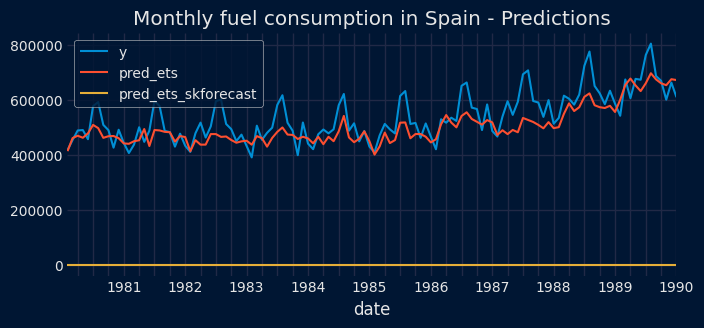

In [19]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_ets_aeon['pred'].plot(ax=ax, label='pred_ets')
pred_ets_skforecast['pred'].plot(ax=ax, label='pred_ets_skforecast')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();